# Purpose

This notebook is to test whether the `neuro_op` module's nodes can successfully infer `world_dist` if only this distribution's information pieces $x_{world}$ are received (i.e., with rates h>0, r=0).

For this, the model is run with nodes receiving different amount of information (i.e., different `t_max`, `h`). Then, each node's posterior predictive distribution (*PPD*), equalling its forecast of future incoming information, is obtained via 
1. sampling of model parameters $\theta$ proportional to its posterior $p(\theta | x_{world})$;
2. using these sampled model parameters to generate data proportional to the model likelihood $p(x_{PPD}|\theta_{sampled})$

PPDs thereby fully conserves uncertainty by paying respect to both posterior and likelihood stochasticity.

We then use the PPDs to quantify the nodes' modelling accuracy by computing the Kullback-Leibler divergence and average MLE distances between node PPDs and data generated by `world_dist`.

In [2]:
# import cProfile
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy.stats as st

import neuro_op as nop

In [20]:
nop.plot_setup()
cmap = "inferno"

In [21]:
# Reference input
input = dict(
    G=nop.build_random_network(N_nodes=100, N_neighbours=5),  # networkx graph object
    # G=nx.empty_graph(1),
    llf_nodes=st.norm,  # Likelihood function (llf) of nodes, Gaussian by default
    llf_world=st.norm,  # Likelihood function (llf) of world, Gaussian by default
    params_node=dict(  # Parameter priors of nodes (mu and associated uncertainty (standard deviation)), Gaussian by default
        loc=0,
        scale=10,
    ),
    sd_llf=1,  # Standard deviation of the likelihood function (llf) of nodes, assumed known & static
    params_world=dict(  # Likelihood function (llf) parameters of world, Gaussian by default
        loc=0,
        scale=1,
    ),
    h=1,  # Rate of external information draw events
    r=1,  # Rate of edge information exchange events
    t0=0,  # Start time of simulation
    t_max=1e3,  # End time of simulation
    t_sample=1,  # Periodicity for which samples and distance measures (KL-div, p-distance) are taken
    sample_bins=201,  # Number of bins used in distance measures
    sample_range=(
        -5,
        5,
    ),  # Interval over which distance measure distributions are considered
    sampling=True,
)

In [22]:
# Exec times (s)
# ---
# llf_instance:     13.1
# llf improved:     7.4
# rng w. params:    6.78
# rng scaled        6.93

In [6]:
# cProfile.run("nop.run_model_Param(**input)")

In [7]:
out1 = nop.run_model_Param(**input)

print(out1["N_events"])

199900


In [8]:
nop.export_hdf5(out1, "test.h5")

In [9]:
out1 = nop.import_hdf5("test.h5")

## Data analysis

Random data analysis test notebook of steps later used in thorough analysis.


In [10]:
# For improving of readability, increase all font sizes of plots. Also, set legend location to upper right.
# plt.rcParams.update(
#    {
#        "font.size": 20,
#        "legend.loc": "upper right",
#    }
# )

#### Data analysis 1

Firstly, extract output values for further analysis:

In [11]:
for i in out1.keys():
    print(i)

world
G
N_events
t_end
t_start
t_exec
seed
nodesConj
mu_nodes
kl_divs



Each node's posteriors are plotted. One should see nodes' posteriors of model parameters (in this case, $\mu$), to converge around the true value. If not, nodes may need more information to converge ($\rightarrow$ increase $t_{max}, h$).


(array([ 3.,  1.,  5.,  7.,  2., 17.,  6.,  9.,  6., 17.,  0., 11.,  3.,
         0.,  0., 10.,  0.,  0.,  0.,  3.]),
 array([0.01343037, 0.01407555, 0.01472073, 0.01536591, 0.01601108,
        0.01665626, 0.01730144, 0.01794662, 0.0185918 , 0.01923698,
        0.01988216, 0.02052733, 0.02117251, 0.02181769, 0.02246287,
        0.02310805, 0.02375323, 0.02439841, 0.02504358, 0.02568876,
        0.02633394]),
 <BarContainer object of 20 artists>)

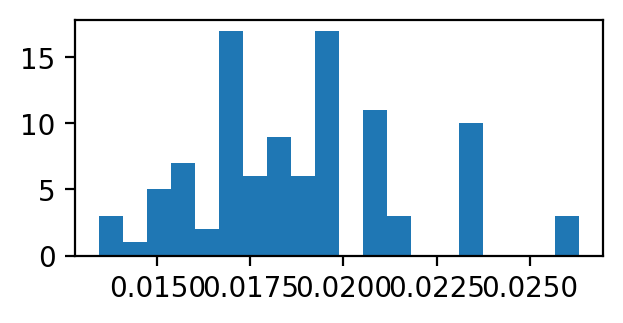

In [12]:
sigmas = []
for i in out1["nodesConj"]:
    sigmas += [i.params_node["scale"]]
fig, ax = plt.subplots()
ax.hist(sigmas, bins=20)

[[ 1.68156654e+01  1.00000000e+00  1.93988019e-01]
 [-1.24548109e+00 -1.00000000e+00  4.50409126e-01]
 [-7.84995054e-01  4.00000000e+00  5.23080494e-01]
 ...
 [-1.61167545e+00 -1.00000000e+00  9.99105015e+02]
 [-1.55843966e+00 -1.00000000e+00  9.99157712e+02]
 [ 1.49913478e-01  4.00000000e+00  9.99494826e+02]]


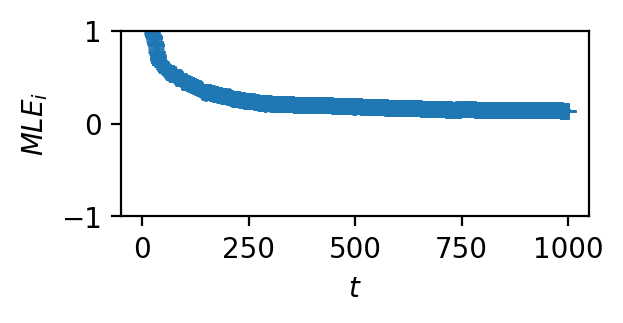

In [17]:
# Implement external sampling routine (or rather test if feasible)
k = 0
nody = out1["nodesConj"][k]
# mu_nody = np.array(out1["mu_nodes"])[:, k][1:]
#
fig, ax = plt.subplots()
# ax.plot(
#    np.arange(input["t0"], input["t_max"], input["t_sample"]),
#    mu_nody,
# )

mu, sig = input["params_node"].values()
sd_llf = input["sd_llf"]
x_in = np.array(nody.diary_in)
post_mu = x_in[:, 0]
post_sig = np.zeros_like(post_mu)

i = -1
post_mu[i], post_sig[i] = mu, sig
for i, _ in enumerate(x_in):
    post_mu[i] = (post_sig[i - 1] ** 2 * x_in[i, 0] + sd_llf**2 * post_mu[i - 1]) / (
        post_sig[i - 1] ** 2 + sd_llf**2
    )
    post_sig[i] = (1 / post_sig[i - 1] ** 2 + 1 / sd_llf**2) ** (-0.5)

ax.set_ylim(-1, 1)
ax.plot(x_in[:, 2], post_mu, "+", alpha=1)
ax.set_xlabel("$t$")
ax.set_ylabel("$MLE_i$")

print(nody.diary_in)
# fig.savefig("graphics-output/mu_N1.png", dpi=1500)

(1001, 100)
1001


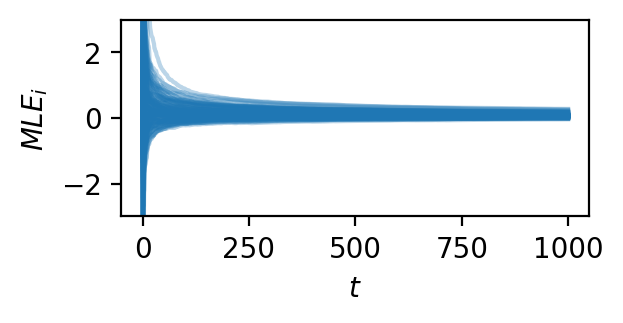

In [37]:
mu_arr = np.array(out1["mu_nodes"])
print(mu_arr.shape)
x = np.arange(input["t0"], input["t_max"] + input["t_sample"], input["t_sample"])
print(len(x))
fig, ax = plt.subplots()
for i, mu in enumerate(mu_arr.T):
    ax.plot(x, mu, alpha=0.3, label=f"$\mu_{i}$", color="tab:blue")
    ax.set_xlabel("$t$")
    ax.set_ylabel("$MLE_i$")
ax.set_ylim(-3, 3)
# ax.set_yscale("log")
# ax.loglog()
# ax.legend()
fig.savefig("./graphics-output/mu_nodes.png", dpi=1500)

#### Data analysis 2

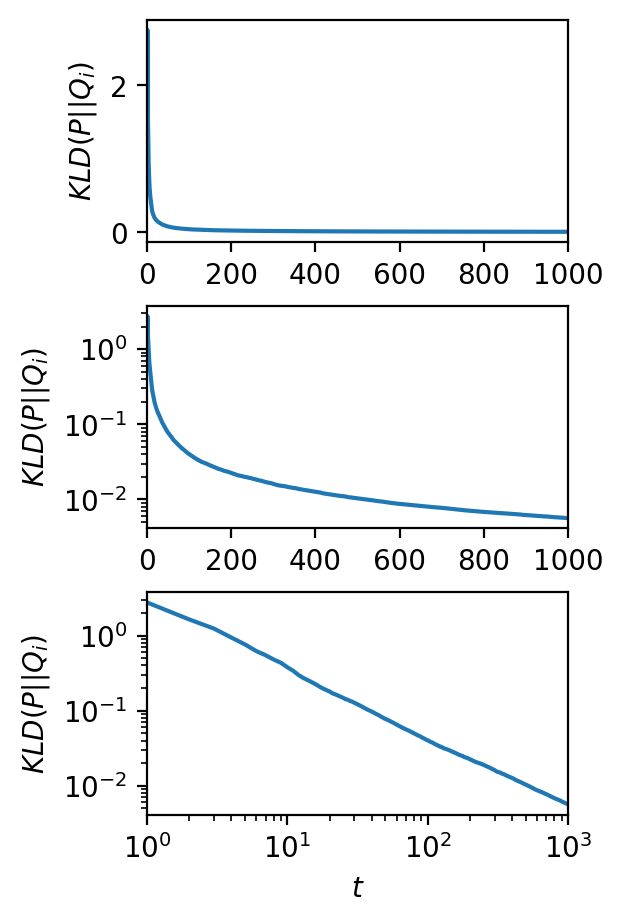

In [58]:
# for i in N_iter:
#    plt.plot(input["t_sample"] * np.arange(0, kld.shape[0]), kld[:, i, ])
kld = np.array(out1["kl_divs"])
fig, ax = plt.subplots(3, 1, constrained_layout=True, figsize=(3, 4.5))
x = input["t_sample"] * np.arange(0, kld.shape[0])
for i, _ in enumerate(ax):
    ax[i].plot(
        x,  # input["t_sample"] * np.arange(0, kld.shape[0]),
        kld.mean(axis=1),
        label="$KLD_i$",
    )
    ax[i].set_ylabel("$KLD(P||Q_i)$")
    ax[i].set_xlim(0, input["t_max"])
ax[2].set_xlabel("$t$")
ax[1].set_yscale("log")
ax[2].loglog()
ax[2].set_xlim(input["t_sample"], input["t_max"])
fig.savefig("./graphics-output/KLD.png", dpi=1500)

(1001, 100)


IndexError: index 100 is out of bounds for axis 1 with size 100

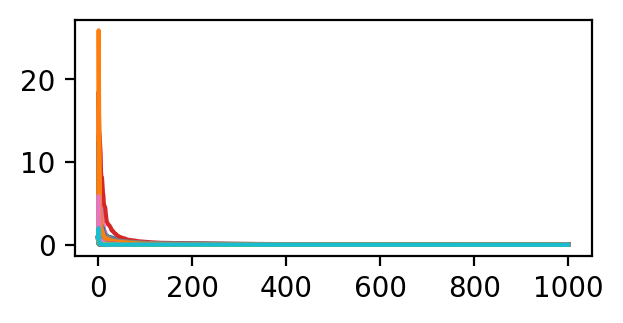

In [16]:
# for i in N_iter:
#    plt.plot(input["t_sample"] * np.arange(0, kld.shape[0]), kld[:, i, ])
kld = np.array(out1["kl_divs"])
print(kld.shape)
fig, ax = plt.subplots(constrained_layout=True, figsize=(3, 1.5))
for i, _ in enumerate(kld):
    ax.plot(
        input["t_sample"] * np.arange(0, kld.shape[0]),
        kld[:, i],
        label="avg",
    )
# plt.loglog()
# plt.ylim(0, 2)

In [ ]:
print(quad_dis.shape)
fig, ax = plt.subplots(constrained_layout=True, figsize=(4, 2))
for i in N_iter:
    ax.plot(input["t_sample"] * np.arange(1, quad_dis.shape[0]), quad_dis[1:, i])

NameError: name 'quad_dis' is not defined

In [ ]:
print(lin_dis.shape)
fig, ax = plt.subplots(constrained_layout=True, figsize=(4, 2))
for i in N_iter:
    ax.plot(input["t_sample"] * np.arange(1, lin_dis.shape[0]), lin_dis[1:, i])

NameError: name 'lin_dis' is not defined

In [ ]:
arr = np.array(out1["p_distances"])
print(arr.shape)
# (arr[-1, 0, 1, :] ** 2).mean()

KeyError: 'p_distances'